<a href="https://colab.research.google.com/github/reitezuz/notebooks-for-NES2-2024/blob/main/lecture_06/cnn_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network - classifying digits from the MNIST dataset

Inspired by: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter08_intro-to-dl-for-computer-vision.ipynb

MNIST dataset is a dataset of handwritten digits. It contains a training set of 60000 greyscale 28x28 images and a testing set of 10000 images of digits written by different people.

https://yann.lecun.com/exdb/mnist/
https://en.wikipedia.org/wiki/MNIST_database

## Load and preprocess the data
- when training CNNs, we don't need the input patterns to be flatten vectors, 3D tensors are OK 

In [1]:
import keras

# Load the MNIST dataset
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# 1. Reshape and normalize the data:
# reshape the data into 4D tensors (54000x28x28x1) and normalize them to the range [0, 1]
x_train = train_images.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = test_images.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = train_labels
y_test = test_labels
print(x_train.shape, y_train.shape)

# 2. Arbitrary: one-hot encode the labels:
# For example, the label 3 would become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].
y_train_categorical = keras.utils.to_categorical(train_labels, num_classes=10)
y_test_categorical  = keras.utils.to_categorical(train_labels, num_classes=10)

print(y_train_categorical.shape)
print(y_train[:3])
print(y_train_categorical[:3])

# 3. Split the training data into training and validation sets
# The validation set is used to monitor the performance of the model during training and prevent overfitting.
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)



(60000, 28, 28, 1) (60000,)
(60000, 10)
[5 0 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## Define and train the model

### Simple CNN model for multiclass classification:
- Start with a keras.Input layer specifying the input shape.
- Add multiple blocks of Conv2D (with 'relu' activation) followed by MaxPooling2D.
- Then add a Flatten layer to convert 2D feature maps to 1D.
- Include one or more Dense layers with 'relu' (or 'tanh') activations for feature extraction.
- Use 'softmax' activation function in the output layer for multiclass classification.

- Loss function and metrics based on label encoding:
    - If labels are one-hot vectors, use `CategoricalCrossentropy` as the loss function and `CategoricalAccuracy` as the metric.
    - If labels are provided as integers, use `SparseCategoricalCrossentropy` as the loss function and `SparseCategoricalAccuracy` as the metric.




In [2]:
# Data frame for results
import pandas as pd

columns = ["Model Name", "Details", "Test Accuracy", "Test Loss"]
results_df = pd.DataFrame(columns=columns)

In [4]:
###############################################
# Define the log directory for TensorBoard
import os
import datetime
import keras
import tensorflow as tf

model_datetime_name = "mnist_cnn_"+  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "./logs/fit_mnist/" + model_datetime_name
# print(os.getcwd())

# Clear any logs from previous runs
# !rm -rf ./logs/

# Ensure the directory exists
if not os.path.exists(os.path.dirname(log_dir)):
    os.makedirs(os.path.dirname(log_dir))

###############################################
# Initialize Tensorboard callback
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # Visualize histograms of layer weights
    write_graph=True,  # Log the graph to visualize the model structure
    write_images=True  # Optionally, save images of weights and activation histograms
    # update_freq='batch'  # Log metrics after every batch
    # write_steps_per_second=True  # Log steps per second during training
)
################################################


# define the model architecture
model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    
    keras.layers.Dense(128, activation='relu'),
    #keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax') 
])

model.summary()

# Set model parameters
model.compile(optimizer= keras.optimizers.Adam(),   # SGD, Adam, RMSProp     
              loss= keras.losses.SparseCategoricalCrossentropy(),                
              metrics= [keras.metrics.SparseCategoricalAccuracy("accuracy")]) 

num_epochs = 8
batch_size = 64

# Train the model
history = model.fit(x_train,
                    y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=[tensorboard_callback])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

# Save the model
model_dir = "./models/"
# Ensure the directory exists
if not os.path.exists(os.path.dirname(model_dir)):
    os.makedirs(os.path.dirname(model_dir))
model_name = model_dir + model_datetime_name + ".keras"
model.save(model_name)

model_details = "32 64 - 128"
# Add results to the dataframe: 
new_entry = {
    "Model Name" : model_datetime_name,
    "Details" : model_details,
    "Test Accuracy" : test_acc, 
    "Test Loss" : test_loss, 
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv(model_dir + "mnist_cnn_results.csv", index=False)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.8833 - loss: 0.3949 - val_accuracy: 0.9837 - val_loss: 0.0554
Epoch 2/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.9834 - loss: 0.0530 - val_accuracy: 0.9842 - val_loss: 0.0503
Epoch 3/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.9894 - loss: 0.0344 - val_accuracy: 0.9843 - val_loss: 0.0468
Epoch 4/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9916 - loss: 0.0262 - val_accuracy: 0.9893 - val_loss: 0.0371
Epoch 5/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.9934 - loss: 0.0195 - val_accuracy: 0.9900 - val_loss: 0.0271
Epoch 6/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9956 - loss: 0.0142 - val_accuracy: 0.9912 - val_loss: 0.0294
Epoch 7/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - accuracy: 0.9962 - loss: 0.0112 - val_accuracy: 0.9877 - val_loss: 0.0444
Epoch 8/8
844/844 ━━━━━━━━━━━━━━━━━━━━ 48s 37ms/step - accuracy: 0.9970 - loss: 0.0095 - val_accu

C:\Users\zuzka\AppData\Local\Temp\ipykernel_133200\836248791.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


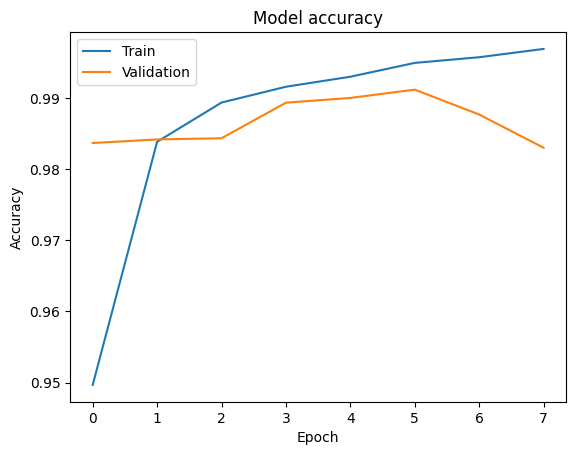

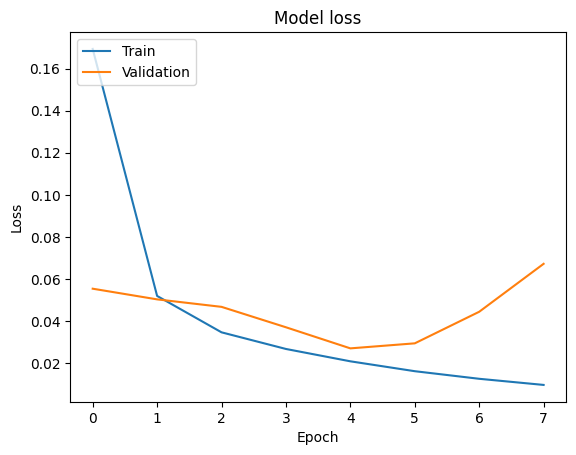

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9891 - loss: 0.0328
Training accuracy: 0.9896296262741089 
Train loss: 0.03145382180809975
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9811 - loss: 0.0698
Validation accuracy: 0.9829999804496765 
Val loss: 0.06722258776426315
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9811 - loss: 0.0760
Test accuracy: 0.9842000007629395 
Test loss: 0.05981580913066864


In [5]:
# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

# Plot training & validation accuracy values
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(x_train, y_train)
print('Training accuracy:', train_acc, '\nTrain loss:', train_loss)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(x_val, y_val)
print('Validation accuracy:', val_acc, '\nVal loss:', val_loss)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

## Evaluate the model and make predictions on new data

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
[3.16247792e-11 4.38453585e-09 2.79030882e-10 1.02662254e-10
 6.83213841e-09 2.30026588e-12 5.58058814e-14 1.00000000e+00
 1.06328939e-11 5.55110091e-09]
Predicted labels: [7 2 1 0 4 1 4 9 5 9]
True labels: [7 2 1 0 4 1 4 9 5 9]
Number of misclassified images: 158 out of 10000 , accuracy 0.9842000007629395


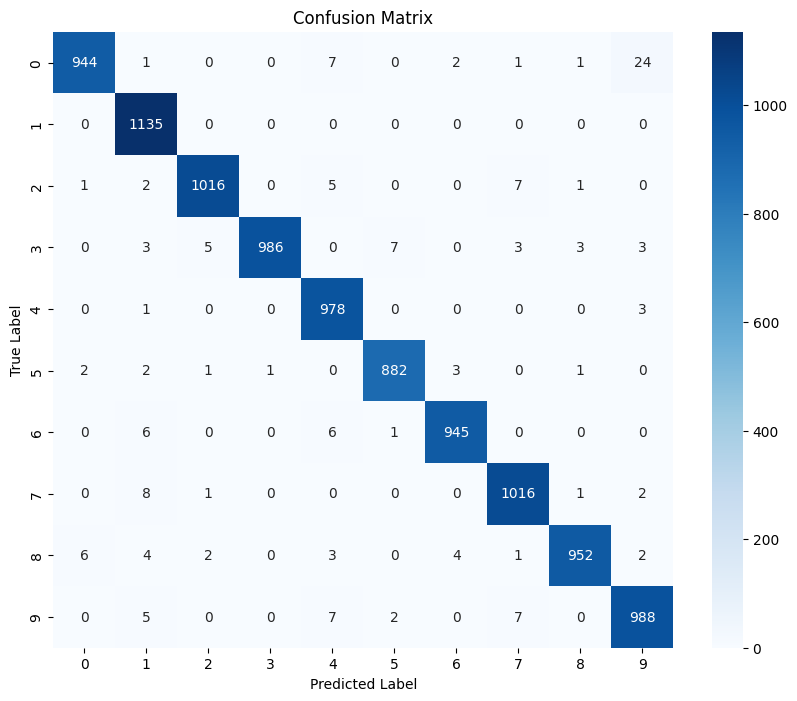

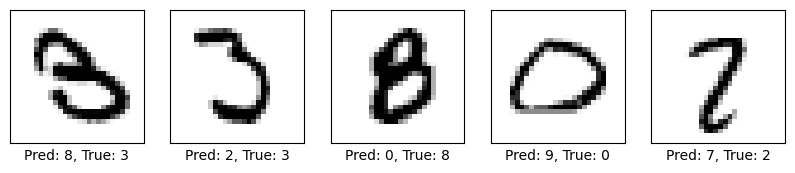

In [7]:
import numpy as np
# Get predicted probabilities for the test set
y_pred_probs = model.predict(x_test)
print(y_pred_probs[0])

# Get the predicted class for each sample
y_pred = np.argmax(y_pred_probs, axis=1)

print("Predicted labels:", y_pred[:10])
print("True labels:", y_test[:10])

# Misclassified indices:
misclassified_indices = np.where(y_pred != y_test)[0]
num_misclassified = len(misclassified_indices)
print("Number of misclassified images:", num_misclassified, 
      "out of", len(y_test), ", accuracy", test_acc)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot some misclassified images
num_images_to_plot = 5
plt.figure(figsize=(10, 10))
for i in range(min(num_images_to_plot, len(misclassified_indices))):
    index = misclassified_indices[i]
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[index], cmap=plt.cm.binary)
    plt.xlabel(f"Pred: {y_pred[index]}, True: {y_test[index]}")
plt.show()

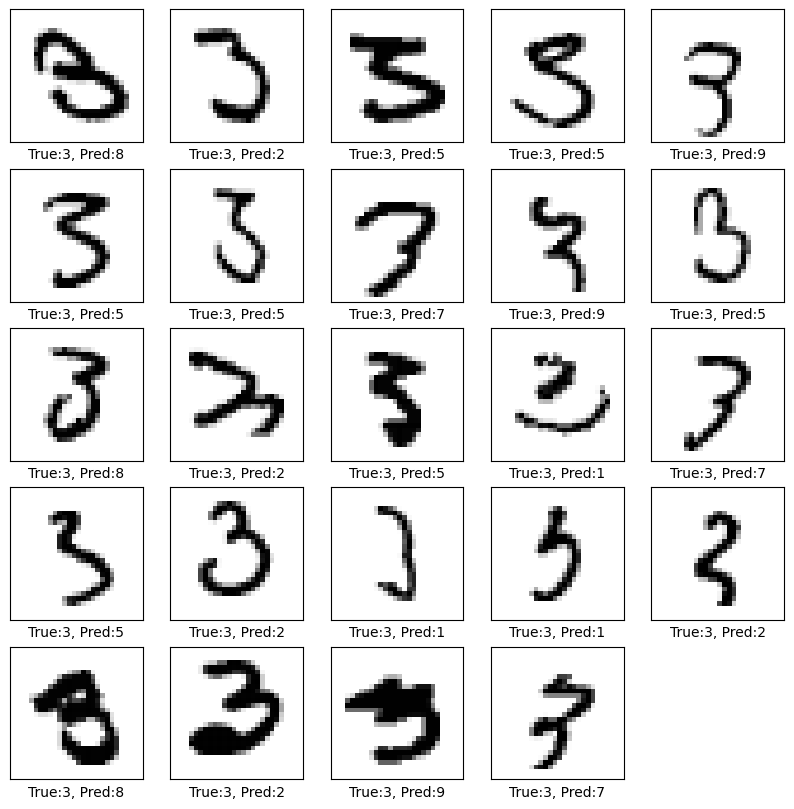

In [8]:
# Plot some misclassified images from a given target (or predicted) class
target_class = 3
misclassified_indices_class = np.where((y_pred != y_test) & (y_test == target_class))[0]
#misclassified_indices_class = np.where((y_pred != y_test) & (y_pred == target_class))[0]



# Display the first 25 misclassified images for the target class
plt.figure(figsize=(10, 10))
for i in range(min(25, len(misclassified_indices_class))):
    index = misclassified_indices_class[i]
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[index], cmap=plt.cm.binary)
    plt.xlabel(f"True:{y_test[index]}, Pred:{y_pred[index]}")
plt.show()


# Exercises
1. **Compare the results with MLP** (see multiclass_classification_mnist.ipynb). In both cases, use the same optimizer (e.g., Adam) and appropriate number of epochs.  
2. **Experiment with the architecture**. For example, use only one convolutional block with additional dense layers. Experiment with kernel sizes and the number of filters.

# More exercises
1. Experiment with the number of epochs and batch size.
2. Change the optimizer of the model.
3. Try standardization of the data instead of simple normalization to [0, 1].
4. Use one-hot encoding of the output data with `CategoricalCrossentropy` as the loss function.



In [9]:
###############################################
# Load TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard before training begins
%tensorboard --logdir logs/fit_mnist --reload_interval=1

Reusing TensorBoard on port 6006 (pid 4864), started 6 days, 13:29:21 ago. (Use '!kill 4864' to kill it.)